In [6]:
import warnings; warnings.filterwarnings("ignore")

In [114]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models, layers

In [162]:
tf.keras.utils.set_random_seed(235813)

- S: 64 batch size
- T: 120 time 
- F: 17 features
- C: 20 channels plants selected - channels

(S, T, F, C)


# (sample, time, width, length, channel)

batch_size, 120, 17, 94 

In [115]:
inputs = layers.Input(shape=(120, 17, 20, 1))

In [116]:
conv_1d = layers.Conv1D(1234, 3, padding="valid")
conv_2d = layers.Conv2D(1234, (3,3), padding="valid")
conv_3d = layers.Conv3D(1234, (3,3,3), padding="valid")
dense = layers.Dense(1234)

In [117]:
print(dense(inputs).shape)
print(conv_1d(inputs).shape)
print(conv_2d(inputs).shape)
print(conv_3d(inputs).shape)
# print(conv_3d(layers.Reshape((120, 17, 20, 1))(inputs)).shape)

(None, 120, 17, 20, 1234)
(None, 120, 17, 18, 1234)
(None, 120, 15, 18, 1234)
(None, 118, 15, 18, 1234)


# Read Data

In [129]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models, layers



In [130]:
df = pd.read_parquet("../data/processed/outlier_removed.parquet")
subset_plants = df.rt_plant_id.unique()[:20]
df = df[df["rt_plant_id"].isin(subset_plants)].reset_index(drop=True)

# df["production_48_lagged"] = df.groupby("rt_plant_id").production.shift(48)


In [131]:
def correlation_ordering(df, initial_start=7):
    corr = pd.pivot_table(
        df[["rt_plant_id", "production"]].reset_index(), 
        index="forecast_dt", columns="rt_plant_id", 
        values="production").corr()
    selected_plant_ids, selected_plants = [], []
    to_append = initial_start
    selected_plant_ids.append(PLANTS[to_append])
    selected_plants.append(to_append)
            
    for _ in range(df.rt_plant_id.nunique()-1):
        corr_series = corr.iloc[to_append].drop(labels=selected_plant_ids)
        to_append = PLANTS.index(corr_series.idxmax())
        selected_plant_ids.append(PLANTS[to_append])
        selected_plants.append(to_append)
    return selected_plants

In [132]:
GENERATE_SPEED_ANGLE = True

weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]

# df = df.set_index("forecast_dt")[["rt_plant_id", "production", "production_48_lagged", *weather_cols]]
df = df.set_index("forecast_dt")[["rt_plant_id", "production", *weather_cols]]

if GENERATE_SPEED_ANGLE:
    for box in ["SW", "NW", "NE", "SE"]:
        df[f"speed_{box}"] = np.sqrt(np.square(df[f"UGRD_80.m.above.ground.{box}"]) + np.square(df[f"VGRD_80.m.above.ground.{box}"]))
        df[f"angle_{box}"] = np.arctan(df[f"UGRD_80.m.above.ground.{box}"] / df[f"VGRD_80.m.above.ground.{box}"])
        
time_indices = sorted(df.index.unique())
train_ratio = 0.8
valid_ratio = 0.1

train_indices = time_indices[:int(len(time_indices) * train_ratio)]
valid_indices = time_indices[int(len(time_indices) * train_ratio):int(len(time_indices) * (train_ratio + valid_ratio))]
test_indices = time_indices[int(len(time_indices) * (train_ratio + valid_ratio)):]

train_df = df.loc[train_indices, :]
valid_df = df.loc[valid_indices, :]
test_df = df.loc[test_indices, :]

PLANTS = sorted(df.rt_plant_id.unique())
selected_plants = correlation_ordering(df)

def expand_plant_dimension(df, selected_plants=None):
    n_loc = len(PLANTS)
    n_time = df.index.nunique()
    cols = [col for col in df.columns if col != "rt_plant_id"]
    n_cols = len(cols)

    df_np = np.zeros((n_time, n_loc, n_cols))
    if selected_plants is not None:
        for i, j in enumerate(selected_plants):
            df_np[:, i, :] = df[df.rt_plant_id == PLANTS[j]][cols].values
    else:
        for i, plant_id in enumerate(PLANTS):
            df_np[:, i, :] = df[df.rt_plant_id == plant_id][cols].values
    return df_np

train_df_np = expand_plant_dimension(train_df, selected_plants)
valid_df_np = expand_plant_dimension(valid_df, selected_plants)
test_df_np = expand_plant_dimension(test_df, selected_plants)

scalers = {}
# for i, plant in enumerate(PLANTS):
for i, j in enumerate(selected_plants):
    plant = PLANTS[j]
    scalers[plant] = MinMaxScaler()
    # train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
    train_df_np[:, i, :] = scalers[plant].fit_transform(train_df_np[:, i, :])
    valid_df_np[:, i, :] = scalers[plant].transform(valid_df_np[:, i, :])
    test_df_np[:, i, :] = scalers[plant].transform(test_df_np[:, i, :])
    
train_df_np = np.array(train_df_np, dtype=np.float32)
valid_df_np = np.array(valid_df_np, dtype=np.float32)
test_df_np = np.array(test_df_np, dtype=np.float32)


In [133]:
print(selected_plants)
print(PLANTS)
print([PLANTS[i] for i in selected_plants])

[7, 8, 6, 18, 10, 19, 12, 4, 9, 11, 13, 17, 14, 15, 16, 5, 0, 2, 3, 1]
[672, 749, 757, 968, 969, 1194, 1459, 1460, 1472, 1484, 1485, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1498]
[1460, 1472, 1459, 1494, 1485, 1498, 1488, 969, 1484, 1487, 1489, 1493, 1490, 1491, 1492, 1194, 672, 757, 968, 749]


In [134]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, valid_df=valid_df, test_df=test_df,
                 columns=None, label_columns=None):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.ndim = self.train_df.ndim
        assert self.ndim in [2, 3]
        if columns is None:
            columns = train_df.columns

        self.label_columns = label_columns
        self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(columns)}
        self.feature_column_indices = [v for k,v in self.column_indices.items() if k not in self.label_columns]
        # self.feature_number = len(self.feature_column_indices)
        if self.train_df.ndim == 2:
            self.number_of_plants = 1
        else:
            self.number_of_plants = self.train_df.shape[1]
        # list(self.label_columns_indices.values())

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.input_shape = (self.input_width, self.number_of_plants, len(self.feature_column_indices))

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :, 1:]
        labels = features[:, self.labels_slice, :, :]
        labels = tf.stack([labels[:, :, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        inputs.set_shape([None, self.input_width, None, None])
        labels.set_shape([None, self.label_width, None, None])
        return inputs, labels

    def plot(self, model=None, plot_col='production', plant=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            
            if plant is not None:
                input_values = inputs[n, :, plant, plot_col_index]
                label_values = labels[n, :, plant, label_col_index]
            else:
                input_values = tf.math.reduce_mean(inputs[n, :, :, plot_col_index], axis=1)
                label_values = tf.math.reduce_mean(labels[n, :, :, label_col_index], axis=1)
                
            plt.plot(self.input_indices, input_values, label='Inputs', marker='.', zorder=-10)

            plt.scatter(self.label_indices, label_values, edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                if plant is not None:
                    prediction_values = predictions[n, :, plant, label_col_index]
                else:
                    prediction_values = tf.math.reduce_mean(predictions[n, :, :, label_col_index], axis=1)
                
                prediction_values = tf.clip_by_value(prediction_values, clip_value_min=0, clip_value_max=1)

                plt.scatter(self.label_indices, prediction_values, marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data, test=False):
        data = np.array(data, dtype=np.float32)
        if test:
            sequence_stride, shuffle = 24, False
        else:
            sequence_stride, shuffle = 1, True 
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=sequence_stride, 
            shuffle=shuffle,
            batch_size=64,)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df, test=True)

    @property
    def test(self):
        return self.make_dataset(self.test_df, test=True)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.test))
            self._example = result
        return result

# End Reading

In [135]:
def wmape(y_true, y_pred):
    total_abs_diff = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(y_true)
    wmape = tf.realdiv(total_abs_diff, total)
    return wmape

MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_wmape',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss="mae",
                  optimizer=tf.optimizers.RMSprop(),
                  metrics=[wmape],
                  steps_per_execution=32,
                  jit_compile=True) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=1,
                        callbacks=[early_stopping])
    return history

In [136]:
OUT_STEPS = 24

columns = [col for col in train_df.columns if col != "rt_plant_id"]

multi_window = WindowGenerator(
    train_df=train_df_np, valid_df=valid_df_np, test_df=test_df_np, columns=columns,
    input_width=120, label_width=24, shift=0, label_columns=["production"])
multi_window

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): ['production']

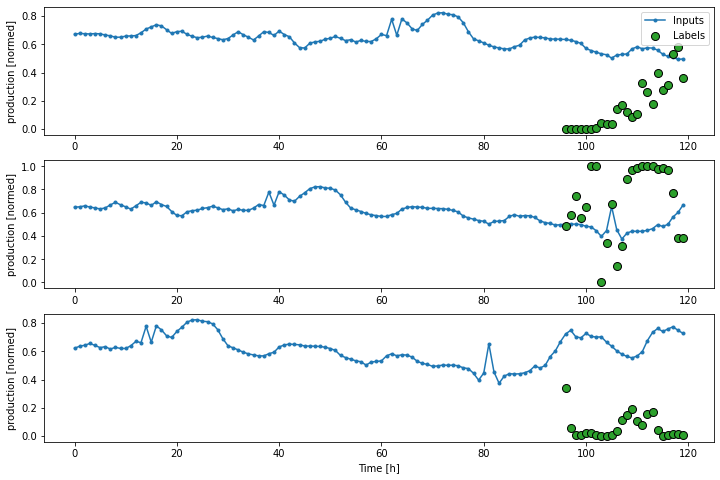

In [137]:
multi_window.plot(plant=0)

## Dense

In [138]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))
model.add(layers.Dense(16, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Dropout(0.2))
model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_41 (Permute)        (None, 20, 120, 16)       0         
                                                                 
 dense_11 (Dense)            (None, 20, 120, 16)       272       
                                                                 
 dropout_3 (Dropout)         (None, 20, 120, 16)       0         
                                                                 
 reshape_17 (Reshape)        (None, 20, 1920)          0         
                                                                 
 dense_12 (Dense)            (None, 20, 24)            46104     
                                                                 
 permute_42 (Permute)        (None, 24, 20)            0         
                                                                 
 reshape_18 (Reshape)        (None, 24, 20, 1)       

In [139]:
history = compile_and_fit(model, multi_window)

Epoch 1/50
160/329 [=============>................] - ETA: 5s - loss: 0.2037 - wmape: 0.6122

KeyboardInterrupt: 

In [140]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))

model.add(layers.Conv2D(64, (CONV_WIDTH, CONV_WIDTH), activation="linear", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))
model.add(layers.Conv2D(32, (CONV_WIDTH, CONV_WIDTH), activation="relu", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))
model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

history = compile_and_fit(model, multi_window)

multi_val_performance['CNN'] = model.evaluate(multi_window.valid)
multi_performance['CNN'] = model.evaluate(multi_window.test)

multi_window.plot(model, plant=0)

Epoch 1/50


KeyboardInterrupt: 

In [99]:
multi_window.input_shape

(120, 20, 17)

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [141]:
## C, T, F
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))

# conv over plants and times
model.add(layers.Conv2D(32, (CONV_WIDTH, CONV_WIDTH), activation="linear", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))

# conv over plants and times
# model.add(layers.Conv2D(32, (CONV_WIDTH, CONV_WIDTH), activation="relu", padding="same"))
# model.add(layers.Permute((2,3,1)))
# model.add(layers.MaxPooling2D(2))
# model.add(layers.Permute((3,1,2)))

model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

history = compile_and_fit(model, multi_window)
multi_val_performance['CNN'] = model.evaluate(multi_window.valid)
multi_performance['CNN'] = model.evaluate(multi_window.test)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_49 (Permute)        (None, 20, 120, 16)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 20, 120, 32)       12832     
                                                                 
 permute_50 (Permute)        (None, 120, 32, 20)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 16, 20)       0         
 g2D)                                                            
                                                                 
 permute_51 (Permute)        (None, 20, 60, 16)        0         
                                                                 
 reshape_21 (Reshape)        (None, 20, 960)           0         
                                                     

In [153]:
## C, T, F
CONV_WIDTH = 5

model = models.Sequential()
# 120, 20, 16
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))

# conv over and times
model.add(layers.Conv1D(32, CONV_WIDTH, activation="linear", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))

model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

history = compile_and_fit(model, multi_window)
multi_val_performance['CNN2'] = model.evaluate(multi_window.valid)
multi_performance['CNN2'] = model.evaluate(multi_window.test)


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_67 (Permute)        (None, 20, 120, 16)       0         
                                                                 
 conv1d_20 (Conv1D)          (None, 20, 120, 32)       2592      
                                                                 
 permute_68 (Permute)        (None, 120, 32, 20)       0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 60, 16, 20)       0         
 g2D)                                                            
                                                                 
 permute_69 (Permute)        (None, 20, 60, 16)        0         
                                                                 
 reshape_25 (Reshape)        (None, 20, 960)           0         
                                                     

In [ ]:
# cnn 
#    Conv2d: conv over plants and times
#    Pool2d: pool over conv filters and times
#    - test wmape  0.335
#    - valid wmape 0.319 

# cnn2
#    Conv1d: conv over times
#    Pool2d: pool over conv filters and times
#    - test wmape  0.356
#    - valid wmape 0.338 

# cnn3
#    Conv1d: conv over times
#    Pool1d: pool over times
#    - test wmape  0.386
#    - valid wmape 0.364

# cnn4
#    Conv1d: conv over plants
#    Pool1d: pool over times
#    - test wmape  0.374
#    - valid wmape 0.357


In [173]:
multi_performance, multi_val_performance

({'CNN': [0.13625876605510712, 0.33501309156417847],
  'CNN2': [0.14432092010974884, 0.35569995641708374],
  'CNN3': [0.15732342004776, 0.3864482641220093],
  'CNN4': [0.1521843820810318, 0.37405258417129517]},
 {'CNN': [0.12281618267297745, 0.3185208737850189],
  'CNN2': [0.13064128160476685, 0.33787453174591064],
  'CNN3': [0.1406308263540268, 0.3639230728149414],
  'CNN4': [0.1377342939376831, 0.3574652671813965]})

In [161]:
## C, T, F
CONV_WIDTH = 5

model = models.Sequential()
# 120, 20, 16
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))

# conv over and times
model.add(layers.Conv1D(32, CONV_WIDTH, activation="linear", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D((2, 1)))
model.add(layers.Permute((3,1,2)))

model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

history = compile_and_fit(model, multi_window)
multi_val_performance['CNN3'] = model.evaluate(multi_window.valid)
multi_performance['CNN3'] = model.evaluate(multi_window.test)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_93 (Permute)        (None, 20, 120, 16)       0         
                                                                 
 conv1d_27 (Conv1D)          (None, 20, 120, 32)       2592      
                                                                 
 permute_94 (Permute)        (None, 120, 32, 20)       0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 60, 32, 20)       0         
 g2D)                                                            
                                                                 
 permute_95 (Permute)        (None, 20, 60, 32)        0         
                                                                 
 reshape_37 (Reshape)        (None, 20, 1920)          0         
                                                     

In [172]:
## C, T, F
CONV_WIDTH = 5

model = models.Sequential()
# 120, 20, 16
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))

# conv over and plants
model.add(layers.Conv2D(32, (CONV_WIDTH, 1), activation="linear", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D((2, 1)))
model.add(layers.Permute((3,1,2)))

model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

history = compile_and_fit(model, multi_window)
multi_val_performance['CNN4'] = model.evaluate(multi_window.valid)
multi_performance['CNN4'] = model.evaluate(multi_window.test)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_111 (Permute)       (None, 20, 120, 16)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 20, 120, 32)       2592      
                                                                 
 permute_112 (Permute)       (None, 120, 32, 20)       0         
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 60, 32, 20)       0         
 g2D)                                                            
                                                                 
 permute_113 (Permute)       (None, 20, 60, 32)        0         
                                                                 
 reshape_43 (Reshape)        (None, 20, 1920)          0         
                                                     

In [ ]:
## C, T, F
CONV_WIDTH = 5

model = models.Sequential()
# 120, 20, 16
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))

# conv over and plants
model.add(layers.Conv2D(32, (CONV_WIDTH, 1), activation="linear", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D((2, 1)))
model.add(layers.Permute((3,1,2)))

model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

history = compile_and_fit(model, multi_window)
multi_val_performance['CNN4'] = model.evaluate(multi_window.valid)
multi_performance['CNN4'] = model.evaluate(multi_window.test)

In [176]:
## C, T, F
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))

# conv over plants and times
model.add(layers.Conv2D(32, (CONV_WIDTH, CONV_WIDTH), activation="linear", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))

# conv over plants and times
model.add(layers.Conv2D(32, (CONV_WIDTH, CONV_WIDTH), activation="relu", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))

model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()



Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_125 (Permute)       (None, 20, 120, 16)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 20, 120, 32)       12832     
                                                                 
 permute_126 (Permute)       (None, 120, 32, 20)       0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 60, 16, 20)       0         
 g2D)                                                            
                                                                 
 permute_127 (Permute)       (None, 20, 60, 16)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 20, 60, 32)        12832     
                                                     

In [177]:
history = compile_and_fit(model, multi_window)
multi_val_performance['CNN5'] = model.evaluate(multi_window.valid)
multi_performance['CNN5'] = model.evaluate(multi_window.test)

Epoch 1/50
329/329 [==============================] - 54s 163ms/step - loss: 0.1636 - wmape: 0.4921 - val_loss: 0.1636 - val_wmape: 0.4252
Epoch 2/50
329/329 [==============================] - 55s 167ms/step - loss: 0.1322 - wmape: 0.3973 - val_loss: 0.1296 - val_wmape: 0.3355
Epoch 3/50
329/329 [==============================] - 61s 187ms/step - loss: 0.1226 - wmape: 0.3688 - val_loss: 0.1282 - val_wmape: 0.3311
Epoch 4/50
329/329 [==============================] - 55s 168ms/step - loss: 0.1184 - wmape: 0.3565 - val_loss: 0.1382 - val_wmape: 0.3553
Epoch 5/50
329/329 [==============================] - 56s 170ms/step - loss: 0.1149 - wmape: 0.3459 - val_loss: 0.1239 - val_wmape: 0.3213
Epoch 6/50
329/329 [==============================] - 56s 170ms/step - loss: 0.1124 - wmape: 0.3384 - val_loss: 0.1166 - val_wmape: 0.3017
Epoch 7/50
329/329 [==============================] - 56s 170ms/step - loss: 0.1098 - wmape: 0.3305 - val_loss: 0.1222 - val_wmape: 0.3166
Epoch 8/50
329/329 [=======

KeyboardInterrupt: 

In [ ]:
## C, T, F
CONV_WIDTH = 5

model = models.Sequential()
# 120, 20, 16
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))

# conv over plants and times
model.add(layers.Conv1D(32, CONV_WIDTH, activation="linear", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))

# conv over plants and times
# model.add(layers.Conv2D(32, (CONV_WIDTH, CONV_WIDTH), activation="relu", padding="same"))
# model.add(layers.Permute((2,3,1)))
# model.add(layers.MaxPooling2D(2))
# model.add(layers.Permute((3,1,2)))

model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS, activation="sigmoid"))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()